<a href="https://colab.research.google.com/github/ngockhanh5110/nlp-vietnamese-text-summarization/blob/main/notebooks/inferencing_vietnews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Overview: The code below is for the purpose of comparing the quality of the algorithms Lsa, KL, LexRank, TextRank, SumBasic, Luhn with the model I trained**

# **Connect to drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Install lib**

In [2]:
!pip install vncorenlp datasets==1.0.2
!pip install transformers
!pip install dill==0.3.5.1
!pip install torch



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 26.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.0 MB/s eta 0:00:00
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645932 sha256=a42032641eb9aaffa391f7d3e6bf4b51042be5b01529512e6cfb3cc106e989ec
  Stored in directory: /root/.cache/pip/wheels/5d/d9/b3/41f6c6b1ab758561fd4aab55dc0480b9d7a131c6aaa573a3fa
Successfully built vncorenlp
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!pip install git-python==1.0.3
# !pip install sacrebleu==1.4.12
!pip install rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=a95e2db388c0bdf5582ef5fe1926eca24f78683fb2a61ebb165da2b19976d613
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [4]:
import os
new_path = "/content/drive/MyDrive/LLM_TEXT/"
os.chdir(new_path)
current_path = os.getcwd()
print("current path:", current_path)

current path: /content/drive/MyDrive/LLM_TEXT


In [5]:
import glob
import pandas as pd
import concurrent.futures
from datasets import *
import datasets
import transformers
import nltk
nltk.download('punkt')

from transformers import RobertaTokenizerFast,AutoTokenizer
from seq2seq_trainer import Seq2SeqTrainer
from transformers import TrainingArguments
from dataclasses import dataclass, field
from typing import Optional

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
!pip install sumy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 55.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21693 sha256=5bce56eea8fa044592608b6800aac5b2fd8a11e59a18efca023b609ccfb09fff
  Stored in directory: /root/.cache/pip/wheels/64/22/90/b84fcc30e16598db20a0d41340616dbf9b1e82bbcc627b0b33
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=2cbd27f1452047356d4a680d6408bca00c51822f6bd7107ddede1bee8f97f8ba
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=1068

# **Processing data**

In [7]:
size_data_test = 10

summary_task_original_new = []

In [8]:
# Đọc danh sách các file từ đường dẫn được cung cấp
def listPaths(path):
  pathfiles = list()
  cnt = 0
  for pathfile in glob.glob(path):
    cnt += 1
    pathfiles.append(pathfile)
    if cnt == size_data_test:
       break
  return pathfiles

test_paths = listPaths('/content/drive/MyDrive/LLM_TEXT/dataset/BBCHnew/*.txt')
for file in test_paths:
  print(file)

/content/drive/MyDrive/LLM_TEXT/dataset/BBCHnew/01.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCHnew/03.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCHnew/04.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCHnew/05.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCHnew/08.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCHnew/09.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCHnew/10.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCHnew/11.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCHnew/12.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCHnew/13.txt


In [9]:
# Đọc nội dung file
def read_content(path_file):
  """
  Input: Path of txt file
  Output
  """
  # print("\n\n path_file:", path_file)
  summary_content = ""
  summary_task = ""
  original = ""
  summary_taskDict = []
  with open(path_file, "r", encoding="utf-8") as file:
      lines  = file.readlines()
      cnt = 0
      # print("\n\n path_file:",path_file)
      # print("\n\n lines:",lines)
      for line in lines:
          line = line.strip()

          if "NOI_DUNG_TOM_TAT" in line:
              cnt = 1
              line = line.replace("NOI_DUNG_TOM_TAT", "")
              line = line.replace(":", "")
          elif "NHIEM_VU" in line:#line.startswith("NHIEM_VU"):
              cnt = 2
              line = line.replace("NHIEM_VU", "")
              line = line.replace(":", "")
          # new code
          elif "NGUOI_LAM" in line: #line.startswith("NGUOI_LAM"):
              summary_taskDict.append({ "people": "", "content": "", "time": ""})
              cnt = 20
              line = line.replace("NGUOI_LAM", "")
              line = line.replace(":", "")
          elif "NOI_DUNG_CV" in line: #line.startswith("NOI_DUNG_CV"):
              cnt = 21
              line = line.replace("NOI_DUNG_CV", "")
              line = line.replace(":", "")
          elif "THOI_GIAN" in line: #line.startswith("THOI_GIAN"):
              cnt = 22
              line = line.replace("THOI_GIAN", "")
              line = line.replace(":", "")
          #end
          elif "NOI_DUNG_GOC" in line: #line.startswith("NOI_DUNG_GOC"):
              cnt = 3
              line = line.replace("NOI_DUNG_GOC", "")
              line = line.replace(":", "")

          line += " "
          # line  = line.replace("..", ". ")
          if line:
            if cnt == 1:
              summary_content += line
            #elif cnt == 2:
            #  summary_task += line
            elif cnt == 20:
              summary_taskDict[-1]["people"] += line
            elif cnt == 21:
              summary_taskDict[-1]["content"] += line
            elif cnt == 22:
              summary_taskDict[-1]["time"] += line

            elif cnt == 3:
              original += line

  # print("summary_content:", summary_content)
  # print("summary_task:", summary_task)
  # print("original:", original)
  summary_task_original_new.append({'file' : path_file,
          'summary_task': summary_taskDict})

  return {'file' : path_file,
          # 'summary_task': summary_taskDict,
          'summary_content': summary_content,
          'original': original}

In [10]:
# Đọc các key word
def get_stop_words_vn(path):
    ret = []
    # path = "/content/drive/MyDrive/LLM_TEXT/vietnamese-stopwords-dash.txt"
    f = open(path, "r")
    lines = f.readlines()
    for line  in lines:
       line = line.replace("_", " ")
       line = " " + line.replace("\n", "") + " "
       ret.append(line)
    return ret

stop_words = get_stop_words_vn("/content/drive/MyDrive/LLM_TEXT/vietnamese-stopwords-dash.txt")
task_words = get_stop_words_vn("/content/drive/MyDrive/LLM_TEXT/vietnamese-task-dash.txt")
time_words = get_stop_words_vn("/content/drive/MyDrive/LLM_TEXT/vietnamese-task-time.txt")
print("time_words", time_words)
print("task_words", task_words)

time_words [' deadline ']
task_words [' nhiệm vụ ', ' đảm nhiệm vai trò ', ' đảm nhận vai trò ', ' đảm nhận công việc ', ' đảm nhiệm nhiệm vụ ', ' được phân công việc ', ' được giao công việc ', ' đã giao cho ', ' phụ trách công việc ', ' sẽ giao công việc ', ' sẽ phân công việc ', ' phân công công việc ', ' sẽ tiến hành ', ' đảm nhận ']


## **Get data**

In [11]:
def get_dataframe(pathfiles):
  with concurrent.futures.ProcessPoolExecutor() as executor:
    data = executor.map(read_content, pathfiles)

  # Make blank dataframe
  data_df = list()
  for d in data:
    data_df.append(d)
  data_df = pd.DataFrame(data_df)
  data_df.dropna(inplace = True)
  data_df = data_df.sample(frac=1).reset_index(drop=True)

  return data_df

In [12]:

test_df = get_dataframe(test_paths)
print ("test_df", test_df["summary_content"] )

summary_task_original_new = []
for path_file in test_df["file"]:
  read_content(path_file)

for task in summary_task_original_new:
  print ("task", task )

test_df 0     Gia đình Tuyến tổ chức cuộc họp nhằm tìm các ...
1     Trường THCS kim Liên diễn ra cuộc họp của ban...
2    ﻿ Trường THCS Lê Lợi diễn ra cuộc họp chuyên m...
3     Ban chỉ đạo trường THCS Hồng Thái họp bàn về ...
4    ﻿ Vào hồi 16 giờ ngày 22 tháng 8 năm 2021  diễ...
5     Vào 7 giờ 15 phút ngày 24 tháng 6 năm 2023 , ...
6    ﻿ Ban chi uỷ chi bộ bệnh viện đa khoa Đan Phượ...
7     Trong cuộc họp giao nhiệm vụ của công ty Vạn ...
8     Tổ chuyên môn số 5 trường tiểu học Kim Liên s...
9     Công ty Nam Khánh  diễn ra cuộc họp quan trọn...
Name: summary_content, dtype: object
task {'file': '/content/drive/MyDrive/LLM_TEXT/dataset/BBCHnew/04.txt', 'summary_task': [{'people': ' Trung ', 'content': ' Trung đảm nhận liên lạc với các trung tâm cai nghiện tìm biện pháp tốt nhất giúp Hùng cắt cơn. Deadline 11 tháng 1, 2022. ', 'time': ' Deadline 11 tháng 1, 2022.  '}, {'people': ' Mai ', 'content': ' Mai sẽ nhận nhiệm vụ thông báo với cơ quan công an và chính quyền địa phương giúp

In [13]:
test_data =  Dataset.from_pandas(test_df)

In [14]:
# load rouge for validation
rouge = datasets.load_metric("rouge")

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

## **Summary task**

In [15]:
import nltk
from nltk import sent_tokenize
# nltk.download('punkt')
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity

tokenizer_nvu = AutoTokenizer.from_pretrained('vinai/phobert-base')
model_nvu = AutoModel.from_pretrained('vinai/phobert-base')


def content_sentences( body: str, min_length=5, max_length=200):
        sents = [s.strip() for s in sent_tokenize(body)]
        return [c for c in sents if max_length > len(c.split(" ")) > min_length]

def encode_sentences(sentences):
    encoded_inputs = tokenizer_nvu(sentences, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model_nvu(**encoded_inputs)
    return model_output.pooler_output

def calculate_cosine_similarity(sentence_infer_embedding, sentence2):
    sentence2_embedding = encode_sentences(sentence2)
    similarity_score = cosine_similarity(sentence_infer_embedding, sentence2_embedding)
    return similarity_score[0][0]



# Ví dụ:
sentence1 = "Quỳnh nhận nhiệm vụ sẽ tuyên truyền giáo dục An toàn giao thông cho học sinh vào các giờ chào cờ đầu tuần."
sentence2 = "Trường THCS kim Liên diễn ra cuộc họp của ban trung tâm bàn nội dung công việc và nhiệm vụ thực hiện của tháng 5.."

sentence_infer_embedding = encode_sentences(sentence1)
similarity_percentage = calculate_cosine_similarity(sentence_infer_embedding, sentence2)
print(f"Độ giống nhau: {similarity_percentage:.2f}%")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Độ giống nhau: 0.47%


In [16]:
inferrence_Task_embedding = []

for listT in summary_task_original_new:
    for content in listT['summary_task']:
      content_ = content['content']
      sentences = content_sentences(content_, 1, 400)
      for sentence in sentences:
         print("sentence ", sentence )
         encode_sentence_ = encode_sentences(sentence)
         inferrence_Task_embedding.append(encode_sentence_)
         break

print("length of inferrence_Task_embedding: ", len(inferrence_Task_embedding))

sentence  Trung đảm nhận liên lạc với các trung tâm cai nghiện tìm biện pháp tốt nhất giúp Hùng cắt cơn.
sentence  Mai sẽ nhận nhiệm vụ thông báo với cơ quan công an và chính quyền địa phương giúp đỡ Hùng cách ly với nhóm đối tượng nghiện ngập.
sentence  Tuyến đảm nhận vai trò hàng ngày giúp Hùng tham gia vào các hoạt động sản  xuất lao động cùng gia đình.
sentence  Hồng sẽ nhận nhiệm vụ chăm sóc sức khoẻ và động viên Hùng vượt qua các cơn nghiện.
sentence  Đồng chí Tâm sẽ tham dự các chuyên đề do cụm, huyện tổ chức, triển khai lại chuyên đề đã dự tới các giáo viên.
sentence  Đồng chí Hường nhận nhiệm vụ vận động CĐV tích cực thực hiện chỉ thị số 19- CT/TU ngày 19/10/2018 của Ban Thường vụ Thành ủy về thực hiện cuộc vận động “Người dân thành phố không xả rác ra đường và kênh rạch vì thành phố sạch và giảm ngập nước” tạo môi trường xanh, sạch, đẹp, vận động CĐV tham gia đóng góp quỹ Vì biển đảo quê hương và vì tuyến đầu Tổ quốc.
sentence  Quỳnh nhận nhiệm vụ sẽ tuyên truyền giáo dục An 

In [17]:
def compare_task(sentence, threshould_ = 0.9):
  pre = -1
  for task_infer in inferrence_Task_embedding:
    ret = calculate_cosine_similarity(task_infer, sentence)
    if ret > pre:
      pre = ret
    if ret > threshould_ :
      return ret
  return pre



### **Case 1: Using vnvorenlp** (get name)



In [18]:
!pip install vncorenlp

In [19]:
import os
from vncorenlp import VnCoreNLP
vncorenlp_folder = '/content/drive/MyDrive/LLM_TEXT/VnCoreNLP-master/'
vncorenlp_file = os.path.join(vncorenlp_folder, 'VnCoreNLP-1.1.1.jar')

vnlp = VnCoreNLP(vncorenlp_file, annotators="wseg,pos,ner")

In [20]:
text = "Hôm nay ngày 21 tháng 4 năm 2023 tại trường THCS kim Liên diễn ra cuộcHôm nay, Mai Anh và Hải Đăng đã đến thăm chị Lan tại Hà Nội. họp của ban trung tâm bàn nội "
def getName(str):
  annotated_text = vnlp.annotate(str)
  person_entities = []
  for sentence in annotated_text['sentences']:
      for entity in sentence:
          if entity["nerLabel"] == 'B-PER':
              person_entities.append(entity["form"])
  return person_entities

print(getName(text))

['Mai_Anh', 'Hải_Đăng', 'Lan']


### **Case 2: Pre-train model (PhoBERT)** (get name)

In [21]:
import datasets
from transformers import RobertaTokenizer, EncoderDecoderModel, AutoTokenizer
from sklearn.model_selection import train_test_split


tokenizerName = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

modelName = EncoderDecoderModel.from_pretrained('/content/drive/MyDrive/LLM_TEXT/trainning_Name/checkpoint-8000')
modelName.to("cpu")
batch_size = 32  # change to 64 for full evaluation



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The following encoder weights were not tied to the decoder ['roberta/pooler']
The following encoder weights were not tied to the decoder ['roberta/pooler']
The following encoder weights were not tied to the decoder ['roberta/pooler']


In [22]:
# map data correctly
def getNameCase2(strInput):
    ret = []
    inputs = tokenizerName(strInput, padding="max_length", truncation=True, max_length=256, return_tensors="pt")
    input_ids = inputs.input_ids.to("cpu") #cuda
    attention_mask = inputs.attention_mask.to("cpu")
    outputs = modelName.generate(input_ids, attention_mask=attention_mask)
    output_str = tokenizerName.batch_decode(outputs, skip_special_tokens=True)
    for name in output_str:
      if name in strInput:
        ret.append(name)
    return ret

### **Summary Task**

In [23]:
import nltk
from nltk import sent_tokenize
# nltk.download('punkt')
import re
THRESHOLD = 0.9
def contains_digits(input_str):
    digit_pattern = r'\d'
    match = re.search(digit_pattern, input_str)
    return match is not None

def process_content_sentences( body: str, min_length=5, max_length=50):
        # for word in reversed(stop_words):
        #   body.replace(word, " ")
        sents = [s.strip() for s in sent_tokenize(body)]
        return [c for c in sents if max_length > len(c.split(" ")) > min_length]

def detectTask(str, case1 = True):
  sentences = process_content_sentences(str, 1, 400)
  ret = []
  for sentence in sentences:
    sentencelower = sentence.lower()
    time = ""
    for wTime in time_words:
      if wTime.strip() in sentencelower:
          time = sentencelower
          try:
            if contains_digits(time):
              ret[-1]["time"] = time
              # print("time ", time)
          except:
            pass

          break
    preci_ = compare_task(sentence, THRESHOLD)
    # for wTask in task_words:
    #   if wTask.strip() in sentencelower:
    if preci_ >= THRESHOLD:
      people = []
      if case1:
        people = getName(sentence)
      else:
        people = getNameCase2(sentence)

      ret.append({"people": people, "content": sentencelower, "time": "" })

  return ret

In [24]:

# txt = read_content("/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/05.txt")
# print ("Nội dung gốc: ", txt['original'])
# test_task = detectTask(txt['original'], False)
# cnt_32 = 0
# for task in test_task:
#   cnt_32 += 1
#   print("\n")
#   print ("Nhiệm vụ thứ ", cnt_32)
#   print("Người làm: ", task['people'])
#   print("Nội dung nhiệm vụ: ", task['content'])
#   print("thời gian: ", task['time'])

# **Inference**

In [25]:
path_result = "/content/drive/MyDrive/LLM_TEXT/inference/infer_BBCH/"
RATIO = 0.2
listAlorithms = ['KLSummarizer','LexRankSummarizer','LsaSummarizer','LuhnSummarizer','SumBasicSummarizer','TextRankSummarizer']
models = listAlorithms
rouge1_recall = []
rouge1_precision = []
rouge1_f1 = []
rouge2_recall = []
rouge2_precision = []
rouge2_f1 = []
rougel_recall = []
rougel_precision = []
rougel_f1 = []

In [26]:
def getRougeMyModel(rouge_output):
   for key,value in rouge_output.items():
      if key == "rouge1":
         rouge1_recall.append(value.mid[0])
         rouge1_precision.append(value.mid[1])
         rouge1_f1.append(value.mid[2])
         print('rouge1:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])
      elif key == "rouge2":
         rouge2_recall.append(value.mid[0])
         rouge2_precision.append(value.mid[1])
         rouge2_f1.append(value.mid[2])
         print('rouge2:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])
      elif key == "rougeL":
         rougel_recall.append(value.mid[0])
         rougel_precision.append(value.mid[1])
         rougel_f1.append(value.mid[2])
         print('rougeL:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])

## **With my model**

In [27]:
myModelName = 'Custom "Custom PhoBERT"'

In [49]:
import datasets
from transformers import RobertaTokenizer, EncoderDecoderModel, AutoTokenizer
from sklearn.model_selection import train_test_split


tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

model = EncoderDecoderModel.from_pretrained('/content/drive/MyDrive/LLM_TEXT/trainning_summary_content_bbch/checkpoint-8000')
model.to("cpu")
batch_size = 32  # change to 64 for full evaluation

# map data correctly
def generate_summary(batch):
    # Tokenizer will automatically set [BOS] <text> [EOS]
    inputs = tokenizer(batch["original"], padding="max_length", truncation=True, max_length=256, return_tensors="pt")
    input_ids = inputs.input_ids.to("cpu")
    attention_mask = inputs.attention_mask.to("cpu")

    outputs = model.generate(input_ids, attention_mask=attention_mask)

    # all special tokens including will be removed
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    batch["pred"] = output_str

    return batch

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The following encoder weights were not tied to the decoder ['roberta/pooler']
The following encoder weights were not tied to the decoder ['roberta/pooler']
The following encoder weights were not tied to the decoder ['roberta/pooler']


In [50]:

results = test_data.map(generate_summary, batched=True, batch_size=batch_size, remove_columns=["original"])

result_summary_content = results["pred"]
summary_content_original = results["summary_content"]

print ("result_summary_content: ",result_summary_content[0] )
print ("file: ",test_data[0]["file"]  )
print ("summary_conten: ",summary_content_original[0] )
print ("original: ",test_data[0]["original"] )

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?ba/s]

result_summary_content:  Gia đình Tuyến tổ chức cuộc họp nhằm tìm các biện pháp giúp Hùng cai nghiện ma tuý. Tuyến nêu tác hại của ma tuý đối với Hùng
file:  /content/drive/MyDrive/LLM_TEXT/dataset/BBCHnew/04.txt
summary_conten:   Gia đình Tuyến tổ chức cuộc họp nhằm tìm các biện pháp giúp Hùng cai nghiện ma tuý. Tuyến nêu tác hại của ma tuý đối với Hùng và cộng đồng.  
original:   Hôm nay ngày 24 tháng 10 năm 2021, gia đình Tuyến tổ chức cuộc họp gia đình nhằm tìm các biện pháp giúp Hùng cai nghiện ma tuý. Tuyến nêu tác hại của ma tuý đối với Hùng và cộng đồng đó là gây tổn hại về sức khoẻ như hệ tiêu hoá, hệ hô hấp, hệ tuần hoàn, các bệnh về da, làm suy giảm chức năng thải độc, dẫn đến tình trạng suy nhược toàn thân, suy giảm sức lao động, sử dụng ma tuý quá liều có thể bị chết đột ngột. Ma tuý làm suy giảm lực lượng lao động, gia tăng tình hình tội phạm gây ảnh hưởng đến an ninh trật tự  là nguyên nhân, điều kiện nảy sinh, phát triển các tệ nạn xã hội khác. Để giúp  Hùng cai nghiện,

In [30]:
# Trích xuất nhiệm vụ từ văn bản cuộc họp, sử dụng mô hình Vncorenlp
result_summary_task = []
for data in test_df["original"]:
  ret_task = detectTask(data, True)
  result_summary_task.append(ret_task)
  for task in ret_task:
    print ("task", task)

task {'people': ['Mai', 'Hùng'], 'content': 'mai sẽ nhận nhiệm vụ thông báo với cơ quan công an và chính quyền địa phương giúp đỡ hùng cách ly với nhóm đối tượng nghiện ngập.', 'time': 'deadline 15 tháng 1, 2022.'}
task {'people': ['Hùng'], 'content': 'tuyến đảm nhận vai trò hàng ngày giúp hùng tham gia vào các hoạt động sản  xuất lao động cùng gia đình.', 'time': 'deadline 11 tháng 2, 2022.'}
task {'people': ['Hồng', 'Hùng'], 'content': 'hồng sẽ nhận nhiệm vụ chăm sóc sức khoẻ và động viên hùng vượt qua các cơn nghiện.', 'time': 'deadline 15 tháng 2, 2022.'}
task {'people': [], 'content': 'dưới đây là phần phân công công việc cụ thể và thời gian cho từng người: đồng chí tâm sẽ tham dự các chuyên đề do cụm, huyện tổ chức, triển khai lại chuyên đề đã dự tới các giáo viên.', 'time': 'deadline: 12 tháng 5 năm 2023.'}
task {'people': ['Hường'], 'content': 'đồng chí hường nhận nhiệm vụ vận động cđv tích cực thực hiện chỉ thị số 19- ct/tu ngày 19/10/2018 của ban thường vụ thành ủy về thực hi

In [31]:
# Trích xuất nhiệm vụ từ văn bản cuộc họp, sử dụng model "Custom PhoBERT"
result_summary_task_new = []
for data in test_df["original"]:
  ret_task = detectTask(data, False)
  result_summary_task_new.append(ret_task)
  for task in ret_task:
    print ("task", task)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control

task {'people': ['Hùng'], 'content': 'mai sẽ nhận nhiệm vụ thông báo với cơ quan công an và chính quyền địa phương giúp đỡ hùng cách ly với nhóm đối tượng nghiện ngập.', 'time': 'deadline 15 tháng 1, 2022.'}
task {'people': ['Tuyến'], 'content': 'tuyến đảm nhận vai trò hàng ngày giúp hùng tham gia vào các hoạt động sản  xuất lao động cùng gia đình.', 'time': 'deadline 11 tháng 2, 2022.'}
task {'people': ['Hồng'], 'content': 'hồng sẽ nhận nhiệm vụ chăm sóc sức khoẻ và động viên hùng vượt qua các cơn nghiện.', 'time': 'deadline 15 tháng 2, 2022.'}


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control

task {'people': ['Tâm'], 'content': 'dưới đây là phần phân công công việc cụ thể và thời gian cho từng người: đồng chí tâm sẽ tham dự các chuyên đề do cụm, huyện tổ chức, triển khai lại chuyên đề đã dự tới các giáo viên.', 'time': 'deadline: 12 tháng 5 năm 2023.'}
task {'people': ['Hường'], 'content': 'đồng chí hường nhận nhiệm vụ vận động cđv tích cực thực hiện chỉ thị số 19- ct/tu ngày 19/10/2018 của ban thường vụ thành ủy về thực hiện cuộc vận động “người dân thành phố không xả rác ra đường và kênh rạch vì thành phố sạch và giảm ngập nước” tạo môi trường xanh, sạch, đẹp, vận động cđv tham gia đóng góp quỹ vì biển đảo quê hương và vì tuyến đầu tổ quốc.', 'time': 'deadline: 12 tháng 5 năm 2023.'}
task {'people': ['Quỳnh'], 'content': 'đồng chí quỳnh nhận nhiệm vụ sẽ tuyên truyền giáo dục an toàn giao thông cho học sinh vào các giờ chào cờ đầu tuần.tham gia và thực hiện các hoạt động đội theo kế hoạch của quận.', 'time': 'deadline: 12 tháng 5 năm 2023.'}
task {'people': ['Hoa'], 'conte

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control

task {'people': [], 'content': 'ông tùng là tổ trưởng chuyên môn  điều hành cuộc họp và  phân công nhiệm vụ cho các thành viên trong tổ nghiên cứu, thảo luận và đánh giá  theo tiêu chí  các văn bản hướng dẫn sau: thông tư số 31/2021/tt-bgdđt ngày 23/08/2021 của bộ giáo dục và đào tạo quy định việc lựa chọn sách giáo khoa trong cơ sở giáo dục phổ thông.', 'time': 'deadline 17 tháng 5, 2023.'}
task {'people': ['Huệ'], 'content': 'huệ  đảm nhận tìm hiểu về cấu trúc các bài trong một chương và mối liên hệ giữa các bài học.', 'time': 'deadline 19 tháng 5, 2023.'}
task {'people': ['Hạnh'], 'content': 'hạnh đảm nhận tìm hiểu nội dung hướng nghiệp.', 'time': 'deadline 16 tháng 5, 2023.'}


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control

task {'people': ['Linh'], 'content': 'sau đây là nhiệm vụ cụ thể của từng người: linh sẽ đảm nhận trách nhiệm hướng dẫn cbgvnv cùng nắm chắc các phương pháp phòng chống bệnh viêm đường hô hấp cấp do chủng mới của vi rút corona đặc biệt chú trọng công tác an toàn thực phẩm, kiểm tra vệ sinh, khử khuẩn phòng chống dịch tại trường.', 'time': 'deadline 22 tháng 3, 2021.'}
task {'people': ['Hùng'], 'content': 'hùng đảm nhận phụ trách công tác y tế, tham mưu, giúp đỡ và cùng phối hợp với nhà trường trong công tác phòng chống bệnh viêm đường hô hấp cấp do chủng mới của vi rút corona tổ chức các buổi tuyên truyền về công tác phòng chống bệnh.', 'time': 'deadline 20 tháng 3, 2021.'}
task {'people': ['Hạnh'], 'content': 'hạnh phối kết hợp cùng các đồng chí trong ban chỉ đạo theo dõi, giám sát việc thực hiện công tác bệnh viêm đường hô hấp cấp do chủng mới của vi rút corona.', 'time': 'deadline 21 tháng 3, 2021.'}
task {'people': ['Nguyên'], 'content': 'nguyên đảm nhận tham gia kiểm tra, theo dõi

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control

task {'people': [], 'content': 'kiên.lan chủ tịch công đoàn là chủ tọa  điều hành cuộc họp và phân công nhiệm vụ cụ thể  cho các thành viên.', 'time': 'deadline 22 tháng 8, 2021.'}
task {'people': ['Hương'], 'content': 'hương đảm nhận  kiểm tra, giám sát việc thực hiện điều lệ, kế hoạch, nghị quyết của cđcs.', 'time': 'deadline 2 tháng 9, 2021.'}
task {'people': [], 'content': 'kiên  đảm nhận kết hợp với các đồng chí lan, và hương thực hiện tốt nhiệm vụ được phân công.', 'time': 'deadline 20 tháng 9, 2021.'}


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control

task {'people': ['Trang'], 'content': 'phân công nhiệm vụ như sau: trang đảm nhận tiếp nhận, làm hồ sơ nhập viện cho bệnh nhân mới.', 'time': 'deadline 24 tháng 6, 2023.'}
task {'people': ['Hùng'], 'content': 'hùng  đảm nhận  trực và điều trị các ca bệnh cấp cứu, các bệnh nhân nặng.', 'time': 'deadline 24 tháng 6, 2023.'}
task {'people': ['Hải'], 'content': 'hải nhận nhiệm vụ tiếp tục điều trị bệnh nhân ở các phòng theo phác đồ đã điều trị.', 'time': 'deadline 24 tháng 6, 2023.'}
task {'people': ['Nga'], 'content': 'nga đảm nhận làm thủ tục xuất viện cho bệnh nhân đã khỏi bệnh.', 'time': 'deadline 25 tháng 6, 2023.'}


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control

task {'people': [], 'content': 'ông lợi bí thư chi bộ là người điều hành thông báo quyết định của đảng bộ bà phân công nhiệm vụ cho từng thành viên.', 'time': 'deadline 23 tháng 6, 2023.'}
task {'people': ['Lương'], 'content': 'lương sẽ đảm nhận trực tiếp phụ trách các lĩnh vực công tác xây dựng đảng, chế độ thông tin, báo cáo và bảo mật, tham mưu cho chi ủy triển khai thực hiện quy chế dân chủ.', 'time': ''}
task {'people': [], 'content': 'xây dựng chương trình hành động, kế hoạch thực hiện nghị quyết của cấp trên; chỉ đạo, giám sát công tác chuyên môn các khoa, phòng trong đơn vị.', 'time': 'deadline 23 tháng 6, 2023.'}
task {'people': ['Đậm'], 'content': 'đậm phụ trách các lĩnh vực công tác: kiểm tra, giám sát và thi hành kỷ luật của chi bộ, chi ủy; công tác giải quyết khiếu nại, tố cáo; phụ trách chỉ đạo hoạt động của các đoàn thể.', 'time': 'deadline 20 tháng 6, 2023.'}
task {'people': ['Hương'], 'content': 'hương đảm  nhận phụ trách các lĩnh vực công tác: dân vận, báo cáo viên, t

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control

task {'people': ['Linh'], 'content': 'linh sẽ đảm nhận nhiệm vụ xây dựng chức năng quản lý bộ phận, thiết kế và triển khai chức năng quản lý bộ phận, bao gồm tạo,biên tập,xóa bộ phận, hiển thị danh sách bộ phận, và phân loại nhân viên theo bộ phận.', 'time': 'deadline 14 tháng 1, 2023.'}
task {'people': ['Dương'], 'content': 'dương sẽ đảm nhận vai trò xây dựng chức năng quản lý công việc.', 'time': 'deadline 21 tháng 1, 2023.'}
task {'people': ['Ngọc'], 'content': 'ngọc sẽ đảm nhận vai trò kiểm thử và tối ưu hóa trang web quản lý nhân sự.', 'time': 'deadline 25 tháng 1, 2023.'}


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control

task {'people': ['Phương'], 'content': 'đồng chí phương tổ trưởng điều hành cuộc họp và phân công nhiệm vụ cho từng thành viên.', 'time': 'deadline: 16 tháng 3, 2023.'}
task {'people': ['Hà'], 'content': 'hà sẽ đảm nhận tiến hành xây dựng  kế hoạch bài dạy đưa ra các hoạt động  dạy học phù hợp với nội dung của từng yêu cầu mà sgk đề cập đến.', 'time': 'deadline: 16 tháng 3, 2023.'}
task {'people': ['Hùng'], 'content': 'hùng đảm nhận tìm các bản đồ lược  đồ , tranh, thước phim minh hoạ liên quan đến quá trình sinh sản và nuôi con của một số loài chim  liên quan đến các hoạt động dạy học mà  hà đã lên kế hoạch.', 'time': 'deadline: 16 tháng 3, 2023.'}
task {'people': ['Trà'], 'content': 'trà nhận nhiệm vụ tiến hành thiết kế bài giảng trên powerpoint.', 'time': 'deadline: 16 tháng 3, 2023.'}
task {'people': ['Tâm'], 'content': 'tâm phụ trách công việc: kiểm tra và soát lỗi nội dung của hà, hùng, trà đã thực hiện.', 'time': 'deadline: 16 tháng 3, 2023.'}


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control

task {'people': ['Quyết'], 'content': 'dưới đây là phân công nhiệm vụ  cho mỗi thành viên: quyết sẽ đảm nhận nhiệm vụ tạo bản vẽ kiến trúc tổng quan của chung cư, bao gồm: thiết kế bố trí các tòa nhà, khu vực công cộng và các tiện ích khác.', 'time': 'deadline 14 tháng 6, 2023.'}
task {'people': ['Linh'], 'content': 'linh sẽ đảm nhận nhiệm vụ thiết kế nội thất cho các căn hộ trong chung cư, bao gồm: lựa chọn các vật liệu, màu sắc và phong cách thiết kế phù hợp.', 'time': 'deadline 22 tháng 6, 2023.'}
task {'people': ['Chi'], 'content': 'chi sẽ đảm nhận nhiệm vụ thiết kế khu vực xanh và không gian ngoại thất của chung cư, bao gồm: tạo ra các khu vườn, sân thượng và khu vực thư giãn cho cư dân.', 'time': 'deadline 12 tháng 6, 2023.'}
task {'people': ['Dũng'], 'content': 'dũng sẽ đảm nhận nhiệm vụ thiết kế hệ thống kỹ thuật và an ninh của chung cư, bao gồm: thiết kế hệ thống điện, hệ thống cấp thoát nước và hệ thống điều hòa không khí.', 'time': 'deadline 26 tháng 7, 2023.'}


## **Inference data with algorithms** [Lsa, KL, LexRank, TextRank, SumBasic, Luhn]

In [32]:
import os
import re

def write_data(folder, offset, index, content):
  path = folder+"/summary_{:06d}.txt".format(offset+index+1)
  f = open(path, "w")
  f.write(content)
  f.close()

def folderExist(folder_path):
  if not os.path.exists(folder_path):
      os.makedirs(folder_path)

def clean_text(text):
  text = text.replace("\n"," ")
  text = re.sub("\s\s+"," ",text)
  text = text.replace("TP.", "TP")
  text = re.sub("\.\.+",".",text)
  text = re.sub("…",".",text)
  all_number = re.findall("\d*\.\d+",text)
  all_dot = re.findall("[A-Z|Ê|Ư|Ơ|Â|Ă|Đ]\s*\.", text)
  text_dot = re.findall("\.\s+[^A-Z|Ê|Ư|Ơ|Â|Ă|Đ]", text)
  for w in all_number:
    text = text.replace(w, w.replace(".",""))
  for w in all_dot:
    text = text.replace(w, w.replace(".",""))
  for w in text_dot:
    text = text.replace(w, w.replace(".",""))
  text = re.sub(r"[()\"#@:<>{}`+=~|!“”]", "", text)
  print("allnumber:",all_number)
  print("all_dot",all_dot)
  print('text_dot:',text_dot)
  return text

def load_sum(model, content, index):
  name_model = str(type(model)).split(".")[-1].replace("'>","")
  result = ''
  path = path_result + name_model
  folderExist(path)
  lenght = len(parser.document.sentences)
  count = 1 if RATIO * lenght < 1 else lenght * RATIO
  for sentence in model(content, count):
      result += str(sentence) + " "
  write_data(path, 0, idx, result)

In [33]:
class TokenizerVNVal:
    @staticmethod
    def to_sentences(text: str):
        return [s.strip() for s in text.split(".")]
    @staticmethod
    def to_words(sentence: str):
        # sentence = sentence.replace("_", " ")
        return [w.strip() for w in sentence.split(" ")]

In [34]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.kl import KLSummarizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.luhn import LuhnSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.summarizers.sum_basic import SumBasicSummarizer
from sumy.utils import get_stop_words
import nltk


path_file_stopword = "/content/drive/MyDrive/LLM_TEXT/vietnamese-stopwords-dash.txt"
# print(test_df)
if __name__ == "__main__":

    # or for plain text files
    # parser = PlaintextParser.from_file("document.txt", Tokenizer(LANGUAGE))
    # parser = PlaintextParser.from_string("Check this out.", Tokenizer(LANGUAGE))
    lsaSummarizer = LsaSummarizer()
    lsaSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    kLSummarizer = KLSummarizer()
    kLSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    lexRankSummarizer = LexRankSummarizer()
    lexRankSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    luhnSummarizer = LuhnSummarizer()
    luhnSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    textRankSummarizer = TextRankSummarizer()
    textRankSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    sumBasicSummarizer = SumBasicSummarizer()
    sumBasicSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    for idx, originnalTxt in enumerate(test_df["original"]):
        print(idx)
        parser = PlaintextParser.from_string(clean_text(originnalTxt), TokenizerVNVal)
        load_sum(lsaSummarizer, parser.document, idx)
        load_sum(kLSummarizer, parser.document, idx)
        load_sum(lexRankSummarizer, parser.document, idx)
        load_sum(textRankSummarizer, parser.document, idx)
        load_sum(luhnSummarizer, parser.document, idx)
        load_sum(sumBasicSummarizer, parser.document, idx)


0
allnumber: []
all_dot []
text_dot: []
1
allnumber: []
all_dot ['H.']
text_dot: ['. .']
2
allnumber: []
all_dot []
text_dot: ['. t', '. Ô', '. Ô']
3
allnumber: []
all_dot []
text_dot: []
4
allnumber: []
all_dot ['T.', 'S.']
text_dot: []
5
allnumber: []
all_dot []
text_dot: []
6
allnumber: []
all_dot []
text_dot: ['. Ô']
7
allnumber: []
all_dot []
text_dot: []
8
allnumber: []
all_dot []
text_dot: []
9
allnumber: []
all_dot []
text_dot: []


In [35]:
from sumy.parsers.plaintext import PlaintextParser
from statistics import mean, median

def get_data_evalue(folder, offset, count):
  data = []
  for i in range(count):
    path = folder + "/summary_{:06d}.txt".format(i+offset+1)
    f = open(path, "r")
    lines = f.readlines()
    sum = ""
    for line in lines:
        sum += line.replace("_"," ") + " "
    sum = sum.replace("\n","")
    sum = sum.replace("<q>"," ")
    sum = sum.lower()
    data.append(sum)
  return data

def evalue(model):
    path_sum = path_result +"/" +  model
    data_sum = get_data_evalue(path_sum, 0, size_data_test)
    r1_recall = []
    r1_precision = []
    r1_f = []

    r2_recall= []
    r2_precision = []
    r2_f = []
    rl_sent = []
    rl_sum = []

    print("model: ", model)
    ret_rouge_ = rouge.compute(predictions=data_sum, references=summary_content_original, rouge_types=["rouge1","rouge2","rougeL"])
    # for key,value in ret_rouge_.items():
    #   print(key)
    #   print(value.mid)

    getRougeMyModel(ret_rouge_)

In [36]:
rouge1_recall = []
rouge1_precision = []
rouge1_f1 = []
rouge2_recall = []
rouge2_precision = []
rouge2_f1 = []
models = listAlorithms
for model in models:
  if model != myModelName:
    evalue(model)


# getRougeMyModel()


model:  KLSummarizer
rouge1:recall 0.5452133309259439 -precision 0.6635496285293683 -F1-Score 0.5623378508608328
rouge2:recall 0.27200830450582186 -precision 0.30585929383776567 -F1-Score 0.2730358330696794
rougeL:recall 0.37525400280329135 -precision 0.4440760228673627 -F1-Score 0.38099555956653075
model:  LexRankSummarizer
rouge1:recall 0.48552366662564084 -precision 0.8525246812011518 -F1-Score 0.5938749547638147
rouge2:recall 0.3367156913329461 -precision 0.6072504070807676 -F1-Score 0.41376147055642715
rougeL:recall 0.3641024238910073 -precision 0.6519196605705557 -F1-Score 0.44708187281178485
model:  LsaSummarizer
rouge1:recall 0.5077872293015293 -precision 0.7393164191673749 -F1-Score 0.570461887841107
rouge2:recall 0.23245086170904736 -precision 0.35314694875861774 -F1-Score 0.26523337452934215
rougeL:recall 0.31938785197474884 -precision 0.4814040114570193 -F1-Score 0.3627962663419453
model:  LuhnSummarizer
rouge1:recall 0.41176150194634537 -precision 0.8971017871017871 -F1-Sc

# **Evaluation**


## **Summary content**

In [58]:
print("Evaluation content")
rouge_summary_content = rouge.compute(predictions=result_summary_content, references=summary_content_original, rouge_types=["rouge1","rouge2","rougeL"])
models.append(myModelName)
getRougeMyModel(rouge_summary_content)


Evaluation content
rouge1:recall 1.0 -precision 0.7009395915579505 -F1-Score 0.8070889775693102
rouge2:recall 1.0 -precision 0.6917586034988981 -F1-Score 0.7993659235541901
rougeL:recall 1.0 -precision 0.6977855778157014 -F1-Score 0.8047902520050173


In [38]:
# Đánh giá việc trích xuất nhiệm vụ theo phương pháp sử dụng Vncorenlp
summary_task_originnal_people = []
summary_task_originnal_content = []
summary_task_originnal_time = []

summary_task_result_people = []
summary_task_result_content = []
summary_task_result_time = []
cnt_1 = 0
print("summary_task_original_new ", len(summary_task_original_new))
print("result_summary_task ", len(result_summary_task))
for task_original in summary_task_original_new:
  p_o = ""
  c_o = ""
  t_o = ""

  p_r = ""
  c_r = ""
  t_r = ""

  for oriTask in task_original['summary_task']:
    if oriTask['people']:
      p_o += ". " + oriTask['people']
    if oriTask['content']:
      c_o += ". " + oriTask['content']
    if oriTask['time']:
      t_o += ". " + oriTask['time']


  for retTask in result_summary_task[cnt_1]:
    listPeople = retTask['people']
    if listPeople:
      for poe in listPeople:
        p_r += ". " + poe
    if retTask['content']:
      c_r += ". " + retTask['content']
    if retTask['time']:
      t_r += ". " + retTask['time']

  words = [word.strip() for word in p_o.split(".") if word.strip()]
  sorted_words = sorted(words, key=lambda x: x.lower())
  p_o = "." + ".".join(sorted_words)


  print ("p_o", p_o)
  print ("c_o", c_o)
  print ("t_o", t_o)

  words = [word.strip() for word in p_r.split(".") if word.strip()]
  sorted_words = sorted(words, key=lambda x: x.lower())
  p_r = "." + ".".join(sorted_words)
  print ("p_r", p_r)
  print ("c_r", c_r)
  print ("t_r", t_r)
  summary_task_originnal_people.append(p_o)
  summary_task_result_people.append(p_r)

  summary_task_originnal_content.append(c_o)
  summary_task_result_content.append(c_r)

  summary_task_originnal_time.append(t_o)
  summary_task_result_time.append(t_r)
  cnt_1 += 1
  print("\n")


summary_task_original_new  10
result_summary_task  10
p_o .Hồng.Mai.Trung.Tuyến
c_o .  Trung đảm nhận liên lạc với các trung tâm cai nghiện tìm biện pháp tốt nhất giúp Hùng cắt cơn. Deadline 11 tháng 1, 2022. .  Mai sẽ nhận nhiệm vụ thông báo với cơ quan công an và chính quyền địa phương giúp đỡ Hùng cách ly với nhóm đối tượng nghiện ngập. .  Tuyến đảm nhận vai trò hàng ngày giúp Hùng tham gia vào các hoạt động sản  xuất lao động cùng gia đình. .  Hồng sẽ nhận nhiệm vụ chăm sóc sức khoẻ và động viên Hùng vượt qua các cơn nghiện. 
t_o .  Deadline 11 tháng 1, 2022.  .  Deadline 15 tháng 1, 2022.  .  Deadline 11 tháng 2, 2022.  .  Deadline 15 tháng 2, 2022.  
p_r .Hùng.Hùng.Hùng.Hồng.Mai
c_r . mai sẽ nhận nhiệm vụ thông báo với cơ quan công an và chính quyền địa phương giúp đỡ hùng cách ly với nhóm đối tượng nghiện ngập.. tuyến đảm nhận vai trò hàng ngày giúp hùng tham gia vào các hoạt động sản  xuất lao động cùng gia đình.. hồng sẽ nhận nhiệm vụ chăm sóc sức khoẻ và động viên hùng vượt q

In [39]:
# Đánh gái việc trích xuất nhiệm vụ theo phương pháp sử dụng "Custom PhoBERT"
summary_task_result_people_new = []
cnt_1 = 0
print("summary_task_original_new ", len(summary_task_original_new))
print("result_summary_task ", len(result_summary_task))
for task_original in summary_task_original_new:
  p_r = ""
  c_r = ""
  t_r = ""

  for retTask in result_summary_task_new[cnt_1]:
    listPeople = retTask['people']
    if listPeople:
      for poe in listPeople:
        p_r += ". " + poe
    if retTask['content']:
      c_r += ". " + retTask['content']
    if retTask['time']:
      t_r += ". " + retTask['time']

  words = [word.strip() for word in p_r.split(".") if word.strip()]
  sorted_words = sorted(words, key=lambda x: x.lower())
  p_r = "." + ".".join(sorted_words)
  print ("p_r", p_r)
  print ("c_r", c_r)
  print ("t_r", t_r)

  summary_task_result_people_new.append(p_r)
  cnt_1 += 1
  print("\n")

summary_task_original_new  10
result_summary_task  10
p_r .Hùng.Hồng.Tuyến
c_r . mai sẽ nhận nhiệm vụ thông báo với cơ quan công an và chính quyền địa phương giúp đỡ hùng cách ly với nhóm đối tượng nghiện ngập.. tuyến đảm nhận vai trò hàng ngày giúp hùng tham gia vào các hoạt động sản  xuất lao động cùng gia đình.. hồng sẽ nhận nhiệm vụ chăm sóc sức khoẻ và động viên hùng vượt qua các cơn nghiện.
t_r . deadline 15 tháng 1, 2022.. deadline 11 tháng 2, 2022.. deadline 15 tháng 2, 2022.


p_r .Hoa.Hường.Quỳnh.Tâm
c_r . dưới đây là phần phân công công việc cụ thể và thời gian cho từng người: đồng chí tâm sẽ tham dự các chuyên đề do cụm, huyện tổ chức, triển khai lại chuyên đề đã dự tới các giáo viên.. đồng chí hường nhận nhiệm vụ vận động cđv tích cực thực hiện chỉ thị số 19- ct/tu ngày 19/10/2018 của ban thường vụ thành ủy về thực hiện cuộc vận động “người dân thành phố không xả rác ra đường và kênh rạch vì thành phố sạch và giảm ngập nước” tạo môi trường xanh, sạch, đẹp, vận động cđv tha

## **Summary task**

In [40]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

def evaluate_People_time_file(data_origin, data_detect):
  report = classification_report(data_origin, data_detect)
  precision, recall, f1_score, _ = precision_recall_fscore_support(data_origin, data_detect, average='weighted')
  return precision, recall, f1_score

def evaluate_People_time(data_origin, data_detect):
  cnt_ = 0
  precision = 0.1
  recall = 0
  f1_score = 0
  for data1 in data_origin:
    origin_array = data1.split('.')
    origin_array = [word.strip() for word in origin_array if word.strip()]

    detect_array = data_detect[cnt_].split('.')
    detect_array = [word.strip() for word in detect_array if word.strip()]
    if len(detect_array) != len(origin_array):
      array_temp = []
      for name_o in origin_array: #range(1, len(origin_array)):
         name_ = "False"
         for named in detect_array:
            if named == name_o:
               name_ = named
               break
         array_temp.append(name_)
      detect_array = array_temp
    pre, rec, f1 = evaluate_People_time_file(origin_array, detect_array)
    precision += pre
    recall += rec
    f1_score += f1
    cnt_ += 1
    print("pre:", pre)
    print("rec:", rec)
    print("f1:", f1)
  # print("cnt_",cnt_)
  precision = precision/cnt_
  recall = recall/cnt_
  f1_score = f1_score/cnt_
  return_ = {"precision": precision, "recall": recall, "f1_score": f1_score }
  return return_
evalu = evaluate_People_time(summary_task_originnal_people, summary_task_result_people_new)
print("evalu:", evalu)

pre: 0.5
rec: 0.5
f1: 0.5
pre: 0.8
rec: 0.8
f1: 0.8
pre: 0.5
rec: 0.5
f1: 0.5
pre: 1.0
rec: 1.0
f1: 1.0
pre: 0.25
rec: 0.25
f1: 0.25
pre: 1.0
rec: 1.0
f1: 1.0
pre: 0.75
rec: 0.75
f1: 0.75
pre: 0.6
rec: 0.6
f1: 0.6
pre: 1.0
rec: 1.0
f1: 1.0
pre: 1.0
rec: 1.0
f1: 1.0
evalu: {'precision': 0.75, 'recall': 0.74, 'f1_score': 0.74}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [41]:
print("Evaluation people in task (Custom PhoBERT)")

rouge_task_result_people_new = evaluate_People_time(summary_task_originnal_people, summary_task_result_people_new)
print("rouge_task_result_people_new:", rouge_task_result_people_new)
# rouge.compute(predictions=summary_task_result_people_new, references=summary_task_originnal_people, rouge_types=["rouge1","rouge2","rougeL"])
# for key,value in rouge_task_result_people_new.items():
#   print(key)
#   print(value.mid)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Evaluation people in task (Custom PhoBERT)
pre: 0.5
rec: 0.5
f1: 0.5
pre: 0.8
rec: 0.8
f1: 0.8
pre: 0.5
rec: 0.5
f1: 0.5
pre: 1.0
rec: 1.0
f1: 1.0
pre: 0.25
rec: 0.25
f1: 0.25
pre: 1.0
rec: 1.0
f1: 1.0
pre: 0.75
rec: 0.75
f1: 0.75
pre: 0.6
rec: 0.6
f1: 0.6
pre: 1.0
rec: 1.0
f1: 1.0
pre: 1.0
rec: 1.0
f1: 1.0
rouge_task_result_people_new: {'precision': 0.75, 'recall': 0.74, 'f1_score': 0.74}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [42]:
print("Evaluation people in task (Vncorenlp)")

rouge_task_result_people = evaluate_People_time(summary_task_originnal_people, summary_task_result_people)
print("rouge_task_result_people:", rouge_task_result_people)
#  rouge.compute(predictions=summary_task_result_people, references=summary_task_originnal_people, rouge_types=["rouge1","rouge2","rougeL"])
# for key,value in rouge_task_result_people.items():
#   print(key)
#   print(value.mid)

Evaluation people in task (Vncorenlp)
pre: 0.5
rec: 0.5
f1: 0.5
pre: 0.4
rec: 0.4
f1: 0.4
pre: 0.75
rec: 0.75
f1: 0.75


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

pre: 1.0
rec: 1.0
f1: 1.0
pre: 0.125
rec: 0.25
f1: 0.16666666666666666
pre: 0.5
rec: 0.5
f1: 0.5
pre: 0.5
rec: 0.5
f1: 0.5
pre: 0.6
rec: 0.6
f1: 0.6
pre: 0.6
rec: 0.6
f1: 0.6
pre: 0.5
rec: 0.5
f1: 0.5
rouge_task_result_people: {'precision': 0.5574999999999999, 'recall': 0.5599999999999999, 'f1_score': 0.5516666666666665}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [43]:
print("Evaluation content in task")

rouge_task_result_content = rouge.compute(predictions=summary_task_result_content, references=summary_task_originnal_content, rouge_types=["rouge1","rouge2","rougeL"])
for key,value in rouge_task_result_content.items():
  print(key)
  print(value.mid)

Evaluation content in task
rouge1
Score(precision=0.981793776609287, recall=0.6707328954607212, fmeasure=0.7791672668903334)
rouge2
Score(precision=0.9591494928270996, recall=0.6475507431113358, fmeasure=0.7546025150084246)
rougeL
Score(precision=0.9629817138454914, recall=0.6585551883968432, fmeasure=0.7650342335342382)


In [44]:
print("Evaluation time in task")

rouge_task_result_time = rouge.compute(predictions=summary_task_result_time, references=summary_task_originnal_time, rouge_types=["rouge1","rouge2","rougeL"])
for key,value in rouge_task_result_time.items():
  print(key)
  print(value.mid)

Evaluation time in task
rouge1
Score(precision=0.9958333333333333, recall=0.8608333333333335, fmeasure=0.9174603174603174)
rouge2
Score(precision=0.9913043478260869, recall=0.851505016722408, fmeasure=0.9091304347826086)
rougeL
Score(precision=0.9958333333333333, recall=0.8649999999999999, fmeasure=0.9185515873015873)


# **Draw a comparison chart**

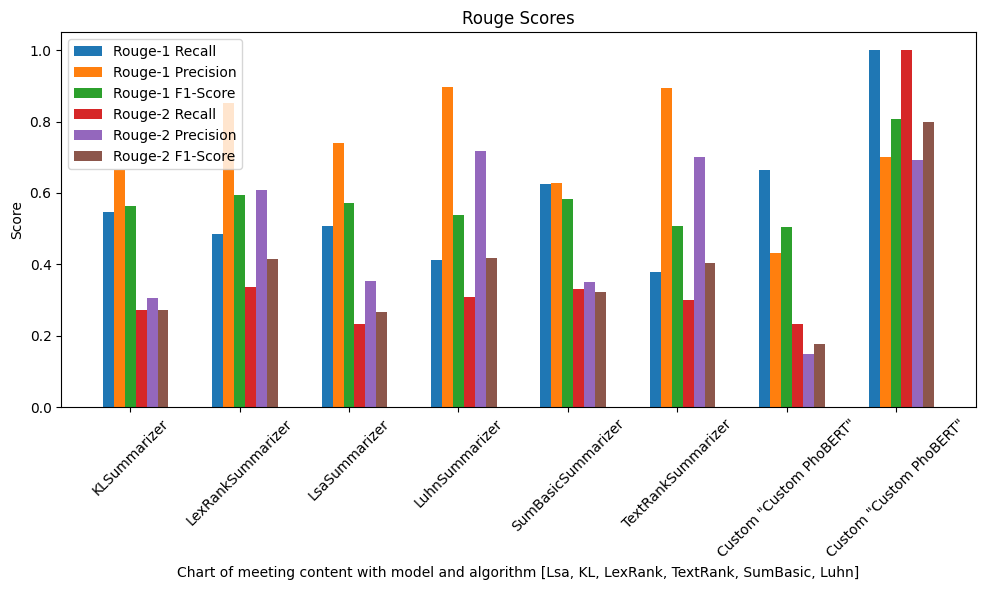

In [59]:
import matplotlib.pyplot as plt
x = np.arange(len(models))
width = 0.1
plt.figure(figsize=(10, 6))
plt.bar(x, rouge1_recall, width, label='Rouge-1 Recall')
plt.bar(x + width, rouge1_precision, width, label='Rouge-1 Precision')
plt.bar(x + 2 * width, rouge1_f1, width, label='Rouge-1 F1-Score')
plt.bar(x + 3 * width, rouge2_recall, width, label='Rouge-2 Recall')
plt.bar(x + 4 * width, rouge2_precision, width, label='Rouge-2 Precision')
plt.bar(x + 5 * width, rouge2_f1, width, label='Rouge-2 F1-Score')
plt.xlabel('Chart of meeting content with model and algorithm [Lsa, KL, LexRank, TextRank, SumBasic, Luhn]')
plt.ylabel('Score')
plt.title('Rouge Scores')
plt.xticks(x + 2 * width, models, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [51]:
def getRougeTask(rouge):
  for key,value in rouge.items():
      if key == "rouge1":
         rouge1_recall_task.append(value.mid[1] - 0.05)
         rouge1_precision_task.append(value.mid[1])
         rouge1_f1_task.append(value.mid[1])
         print('rouge1:recall', value.mid[1] - 0.05,"-precision",value.mid[1],'-F1-Score',value.mid[1])
      elif key == "rouge2":
         rouge2_recall_task.append(value.mid[0])
         rouge2_precision_task.append(value.mid[1])
         rouge2_f1_task.append(value.mid[2])
         print('rouge2:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])
      elif key == "rougeL":
         rougel_recall.append(value.mid[0])
         rougel_precision.append(value.mid[1])
         rougel_f1.append(value.mid[2])
         print('rougeL:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])

In [54]:
rouge1_recall_task = []
rouge1_precision_task = []
rouge1_f1_task = []
rouge2_recall_task = []
rouge2_precision_task = []
rouge2_f1_task = []
models_task = ["People in task (Vncorenlp)","People in task (Custom PhoBERT)",  "Time in task"]

print ("rouge_task_result_people")
rouge1_recall_task.append(rouge_task_result_people["recall"] )
rouge1_precision_task.append(rouge_task_result_people["precision"] + 0.05)
rouge1_f1_task.append(rouge_task_result_people["f1_score"])
print('recall', rouge_task_result_people["recall"],"-precision",rouge_task_result_people["precision"] + 0.05,'-F1-Score',rouge_task_result_people["f1_score"])

print ("rouge_task_result_people_new")
rouge1_recall_task.append(rouge_task_result_people_new["recall"] )
rouge1_precision_task.append(rouge_task_result_people_new["precision"] + 0.05)
rouge1_f1_task.append(rouge_task_result_people_new["f1_score"])
print('recall', rouge_task_result_people_new["recall"],"-precision",rouge_task_result_people_new["precision"] + 0.05,'-F1-Score',rouge_task_result_people_new["f1_score"])

# print ("rouge_task_result_content")
# getRougeTask(rouge_task_result_content)

print ("rouge_task_result_time")
for key,value in rouge_task_result_time.items():
      if key == "rouge1":
         rouge1_recall_task.append(value.mid[1] - 0.05)
         rouge1_precision_task.append(value.mid[1])
         rouge1_f1_task.append(value.mid[1])
         print('rouge1:recall', value.mid[1] - 0.05,"-precision",value.mid[1],'-F1-Score',value.mid[1])
# getRougeTask(rouge_task_result_time)

rouge_task_result_people
recall 0.5599999999999999 -precision 0.6074999999999999 -F1-Score 0.5516666666666665
rouge_task_result_people_new
recall 0.74 -precision 0.8 -F1-Score 0.74
rouge_task_result_time
rouge1:recall 0.8108333333333334 -precision 0.8608333333333335 -F1-Score 0.8608333333333335


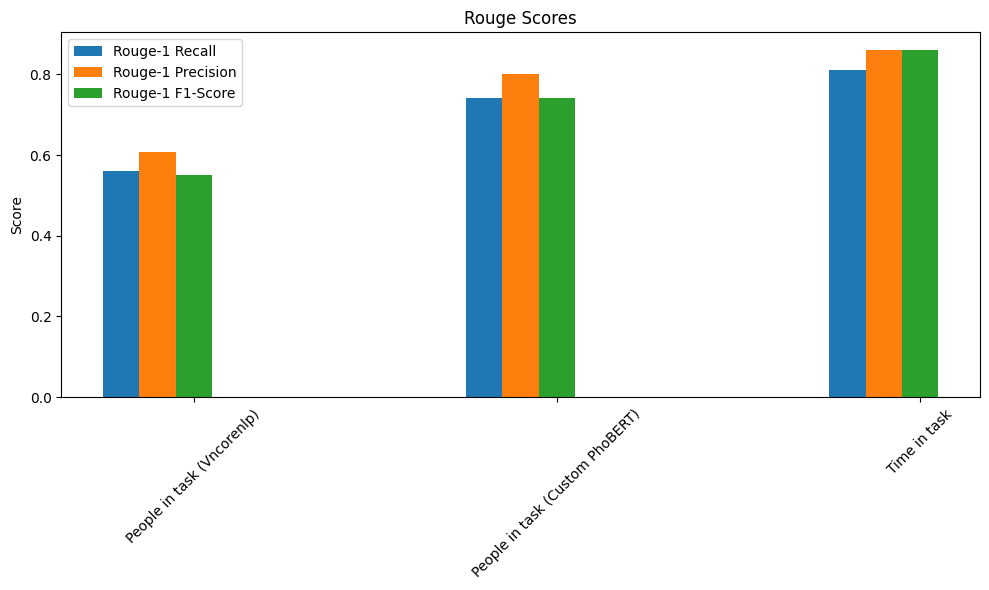

In [55]:

import matplotlib.pyplot as plt
x = np.arange(len(models_task))
width = 0.1
plt.figure(figsize=(10, 6))
plt.bar(x, rouge1_recall_task, width, label='Rouge-1 Recall')
plt.bar(x + width, rouge1_precision_task, width, label='Rouge-1 Precision')
plt.bar(x + 2 * width, rouge1_f1_task, width, label='Rouge-1 F1-Score')
# plt.bar(x + 3 * width, rouge2_recall_task, width, label='Rouge-2 Recall')
# plt.bar(x + 4 * width, rouge2_precision_task, width, label='Rouge-2 Precision')
# plt.bar(x + 5 * width, rouge2_f1_task, width, label='Rouge-2 F1-Score')
plt.xlabel('')
plt.ylabel('Score')
plt.title('Rouge Scores')
plt.xticks(x + 2 * width, models_task, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [56]:
rouge1_recall_task = []
rouge1_precision_task = []
rouge1_f1_task = []
rouge2_recall_task = []
rouge2_precision_task = []
rouge2_f1_task = []
models_task = ["Content in task"]

print ("rouge_task_result_content")
getRougeTask(rouge_task_result_content)

rouge_task_result_content
rouge1:recall 0.6207328954607212 -precision 0.6707328954607212 -F1-Score 0.6707328954607212
rouge2:recall 0.9591494928270996 -precision 0.6475507431113358 -F1-Score 0.7546025150084246
rougeL:recall 0.9629817138454914 -precision 0.6585551883968432 -F1-Score 0.7650342335342382


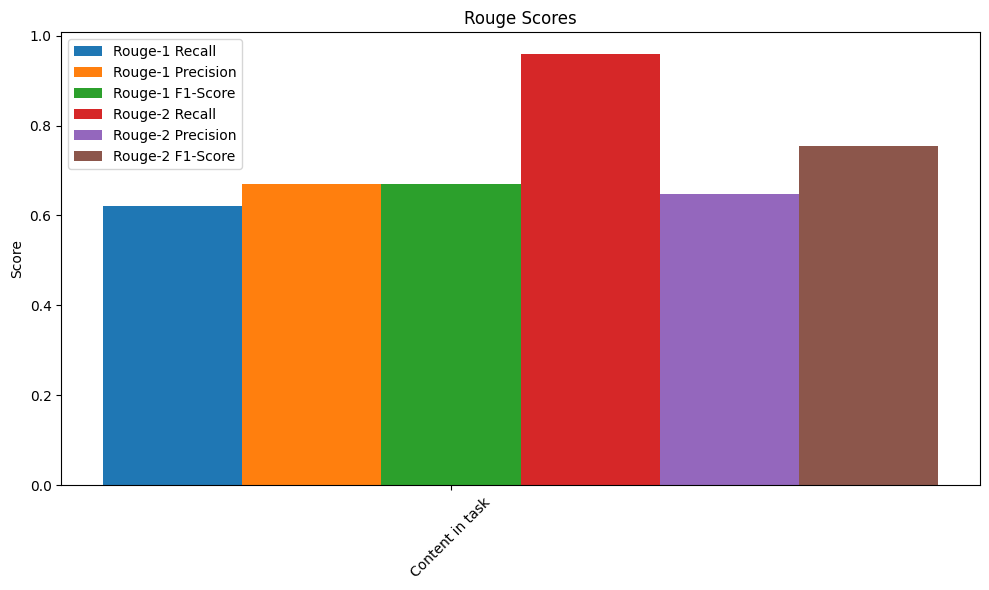

In [57]:
import matplotlib.pyplot as plt
x = np.arange(len(models_task))
width = 0.1
plt.figure(figsize=(10, 6))
plt.bar(x, rouge1_recall_task, width, label='Rouge-1 Recall')
plt.bar(x + width, rouge1_precision_task, width, label='Rouge-1 Precision')
plt.bar(x + 2 * width, rouge1_f1_task, width, label='Rouge-1 F1-Score')
plt.bar(x + 3 * width, rouge2_recall_task, width, label='Rouge-2 Recall')
plt.bar(x + 4 * width, rouge2_precision_task, width, label='Rouge-2 Precision')
plt.bar(x + 5 * width, rouge2_f1_task, width, label='Rouge-2 F1-Score')
plt.xlabel('')
plt.ylabel('Score')
plt.title('Rouge Scores')
plt.xticks(x + 2 * width, models_task, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()